In [1]:
import numpy as np
import pandas as pd
import itertools
import os, stat, time
from os.path import dirname as up
import random
import shutil
import glob
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [2]:
# Plot Settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [3]:
from glob import glob
full_data = glob('./Images/**/*.png', recursive=True)
random.shuffle(full_data)
data = full_data[:85000]
del full_data

In [4]:
len(data)

85000

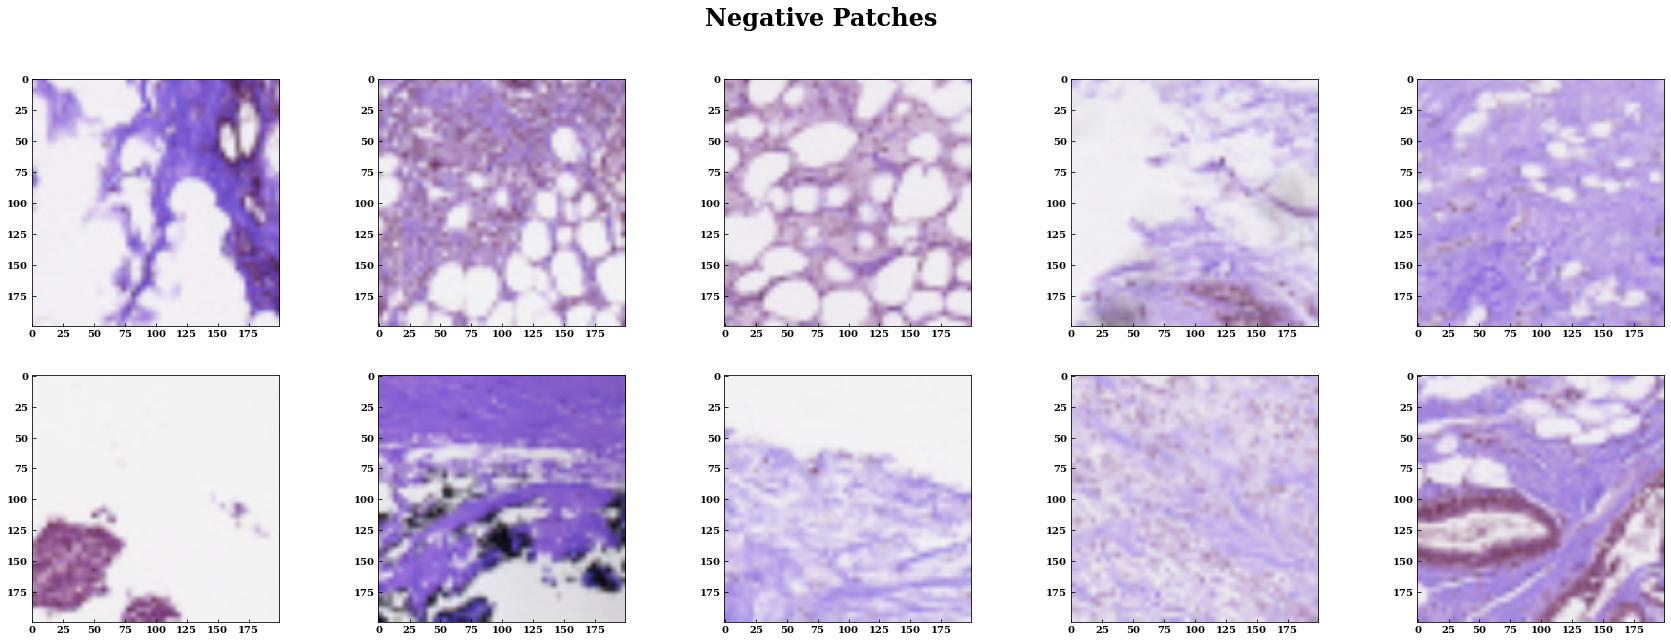

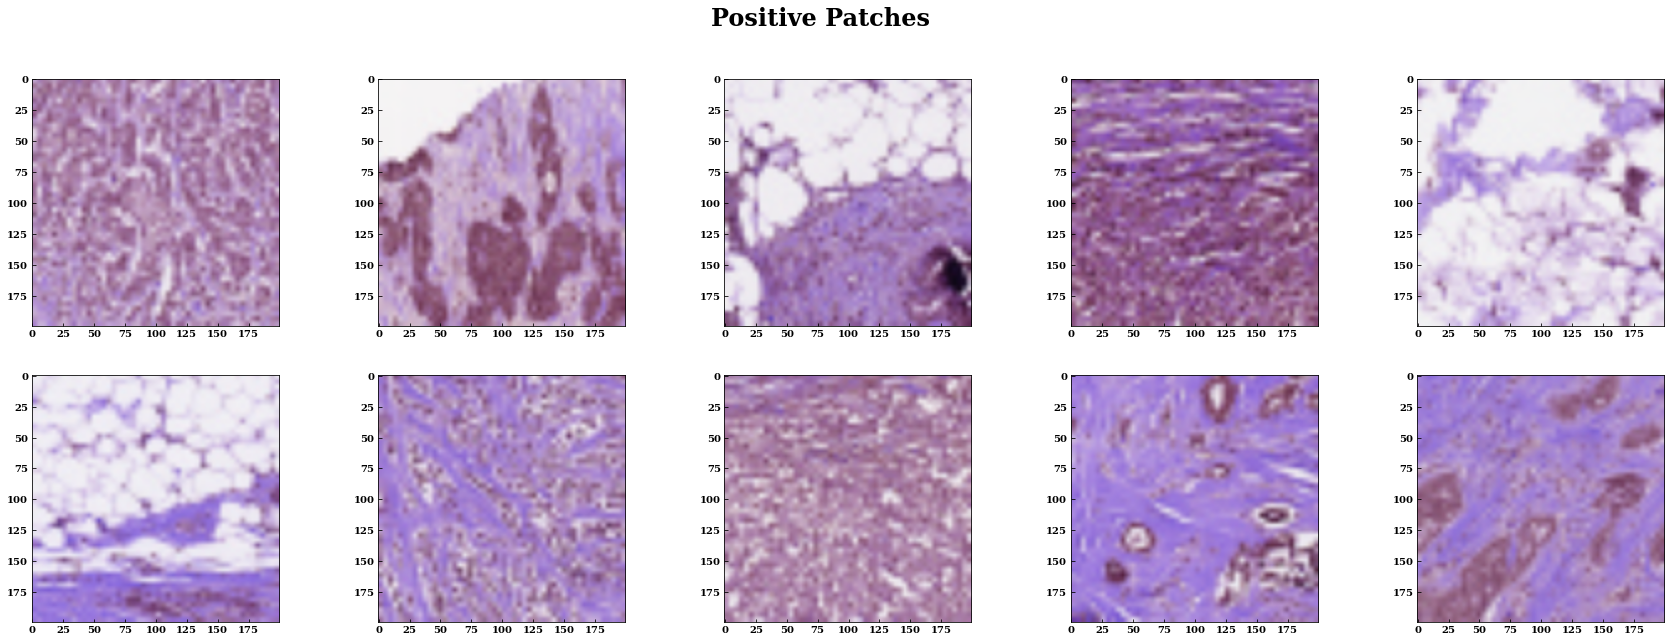

In [5]:
# Negative Patches
fig, ax = plt.subplots(2, 5,figsize = (30,10))

n_plots = 0
for i in data[:1000]:

    if (i[-5]=='0'):
        img = cv2.imread(i)
        img_temp = cv2.resize(img,(200,200))
        ax[n_plots//5, n_plots%5].imshow(img_temp, cmap='binary')
        ax[n_plots//5, n_plots%5].grid(False)
        n_plots += 1
        
    if (n_plots==10): 
        break

fig.suptitle('Negative Patches', fontsize=24, fontweight='bold')
plt.show()

# Positive Patches
fig, ax = plt.subplots(2, 5,figsize = (30,10))

n_plots = 0

for i in data[:2000]:

    if (i[-5]=='1'):
        img = cv2.imread(i)
        img_temp = cv2.resize(img,(200,200))
        ax[n_plots//5, n_plots%5].imshow(img_temp, cmap='binary')
        ax[n_plots//5, n_plots%5].grid(False)
        n_plots += 1
        
    if (n_plots==10): 
        break

fig.suptitle('Positive Patches', fontsize=24, fontweight='bold')
plt.show()

In [6]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [7]:
torch.__version__

'1.9.0+cu111'

In [8]:
# Check is GPU is available, and if so, use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
# Load the image data into torch.DataLoader for training use
def data_loader(data, index_low, index_high):
    
    images, labels = [], []
    
    for img_name in data[index_low:index_high]:
        if img_name.endswith('.png'):
            label = img_name[-5]
            img = cv2.imread(img_name)
            img_temp = cv2.resize(img,(224,224))
            images.append(img_temp.astype(np.float32))
            labels.append(int(label))        
    
    data_set = []
    for i in range(len(labels)):
        data_set.append([images[i], labels[i]])
    
    # random.shuffle(data_set) 
    
    print ('    Number of images with label 1:', np.sum(labels))
    
    # train_set, val_set = torch.utils.data.random_split(data_set, [int(len(data_set)*0.8), int(len(data_set)*0.2)], 
    #                                                    generator=torch.Generator().manual_seed(42))
    
    train_set = torch.utils.data.Subset(data_set, range(int(len(data_set)*0.8)))
    val_set = torch.utils.data.Subset(data_set, range(int(len(data_set)*0.8), len(data_set)))

    image_datasets = {
        'train': train_set,
        'validation': val_set
    }
    
    batch_size = 64
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

    dataloaders = {
        'train': train_dataloader,
        'validation': val_dataloader
    }
    
    return image_datasets, dataloaders

In [10]:
# Load the pre-trained GoogLeNet model
model = models.googlenet(pretrained=True).to(device)

model.fc = nn.Sequential(
               nn.Linear(1024, 64),
               nn.Linear(64, 2),
               nn.Softmax(dim=1)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0000008, betas=(0.9, 0.999), weight_decay=1e-2, eps=1e-08, amsgrad=False)

In [11]:
# Train the model
def train_model(model, criterion, optimizer, num_epochs=3, num_sets=2, num_perset=2000):
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    
    for epoch in range(num_epochs):
            
        print()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 50)    
        
        for i_set in range(num_sets):
        
            print ('  Data {}/{}'.format(i_set+1, num_sets))
            image_datasets, dataloaders = data_loader(data, i_set*num_perset, (i_set+1)*num_perset)

            for phase in ['train', 'validation']:
            
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(torch.transpose(torch.transpose(inputs, 1, 3), 2, 3))
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    # print (outputs)
                    _, preds = torch.max(outputs, 1)
                    # print ('Outputs:', outputs)
                    # print ('Preds:', preds)
                    # print ('Labels:', labels.data)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    # print ('Running corrects:', running_corrects)

                epoch_loss = running_loss / len(image_datasets[phase])
                epoch_acc = running_corrects / len(image_datasets[phase])

                if phase == 'train':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                else:
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)

                print('      {} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                                  epoch_loss,
                                                                  epoch_acc))
                
            del image_datasets, dataloaders
                    
        stats = {'train loss': train_loss,
                 'train accuracy': train_acc,
                 'validation loss': val_loss,
                 'validation accuracy': val_acc}
    
    return model, stats

In [12]:
# Model training
model_trained, stats_trained = train_model(model, criterion, optimizer, num_epochs=20, num_sets=10, num_perset=8000)


Epoch 1/20
--------------------------------------------------
  Data 1/10
    Number of images with label 1: 2264


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


      train loss: 0.6679, acc: 0.6861
      validation loss: 0.6526, acc: 0.7319
  Data 2/10
    Number of images with label 1: 2320
      train loss: 0.6485, acc: 0.7212
      validation loss: 0.6350, acc: 0.7287
  Data 3/10
    Number of images with label 1: 2227
      train loss: 0.6297, acc: 0.7327
      validation loss: 0.6168, acc: 0.7344
  Data 4/10
    Number of images with label 1: 2325
      train loss: 0.6170, acc: 0.7259
      validation loss: 0.6077, acc: 0.7350
  Data 5/10
    Number of images with label 1: 2236
      train loss: 0.6020, acc: 0.7398
      validation loss: 0.5973, acc: 0.7294
  Data 6/10
    Number of images with label 1: 2256
      train loss: 0.5912, acc: 0.7347
      validation loss: 0.5850, acc: 0.7512
  Data 7/10
    Number of images with label 1: 2274
      train loss: 0.5812, acc: 0.7469
      validation loss: 0.5778, acc: 0.7519
  Data 8/10
    Number of images with label 1: 2246
      train loss: 0.5716, acc: 0.7523
      validation loss: 0.5716, 

      validation loss: 0.4446, acc: 0.8669

Epoch 7/20
--------------------------------------------------
  Data 1/10
    Number of images with label 1: 2264
      train loss: 0.4543, acc: 0.8544
      validation loss: 0.4481, acc: 0.8625
  Data 2/10
    Number of images with label 1: 2320
      train loss: 0.4486, acc: 0.8612
      validation loss: 0.4331, acc: 0.8800
  Data 3/10
    Number of images with label 1: 2227
      train loss: 0.4444, acc: 0.8672
      validation loss: 0.4392, acc: 0.8725
  Data 4/10
    Number of images with label 1: 2325
      train loss: 0.4467, acc: 0.8617
      validation loss: 0.4388, acc: 0.8769
  Data 5/10
    Number of images with label 1: 2236
      train loss: 0.4473, acc: 0.8639
      validation loss: 0.4413, acc: 0.8781
  Data 6/10
    Number of images with label 1: 2256
      train loss: 0.4477, acc: 0.8628
      validation loss: 0.4576, acc: 0.8431
  Data 7/10
    Number of images with label 1: 2274
      train loss: 0.4450, acc: 0.8645
      

      train loss: 0.4361, acc: 0.8731
      validation loss: 0.4387, acc: 0.8662
  Data 10/10
    Number of images with label 1: 2248
      train loss: 0.4270, acc: 0.8827
      validation loss: 0.4310, acc: 0.8731

Epoch 13/20
--------------------------------------------------
  Data 1/10
    Number of images with label 1: 2264
      train loss: 0.4379, acc: 0.8700
      validation loss: 0.4373, acc: 0.8687
  Data 2/10
    Number of images with label 1: 2320
      train loss: 0.4320, acc: 0.8789
      validation loss: 0.4240, acc: 0.8794
  Data 3/10
    Number of images with label 1: 2227
      train loss: 0.4303, acc: 0.8800
      validation loss: 0.4278, acc: 0.8831
  Data 4/10
    Number of images with label 1: 2325
      train loss: 0.4328, acc: 0.8753
      validation loss: 0.4272, acc: 0.8800
  Data 5/10
    Number of images with label 1: 2236
      train loss: 0.4339, acc: 0.8781
      validation loss: 0.4315, acc: 0.8794
  Data 6/10
    Number of images with label 1: 2256
    

    Number of images with label 1: 2248
      train loss: 0.4170, acc: 0.8939
      validation loss: 0.4249, acc: 0.8837

Epoch 19/20
--------------------------------------------------
  Data 1/10
    Number of images with label 1: 2264
      train loss: 0.4293, acc: 0.8800
      validation loss: 0.4334, acc: 0.8781
  Data 2/10
    Number of images with label 1: 2320
      train loss: 0.4218, acc: 0.8902
      validation loss: 0.4212, acc: 0.8875
  Data 3/10
    Number of images with label 1: 2227
      train loss: 0.4197, acc: 0.8916
      validation loss: 0.4235, acc: 0.8819
  Data 4/10
    Number of images with label 1: 2325
      train loss: 0.4224, acc: 0.8903
      validation loss: 0.4211, acc: 0.8887
  Data 5/10
    Number of images with label 1: 2236
      train loss: 0.4242, acc: 0.8873
      validation loss: 0.4274, acc: 0.8787
  Data 6/10
    Number of images with label 1: 2256
      train loss: 0.4215, acc: 0.8894
      validation loss: 0.4375, acc: 0.8681
  Data 7/10
    N

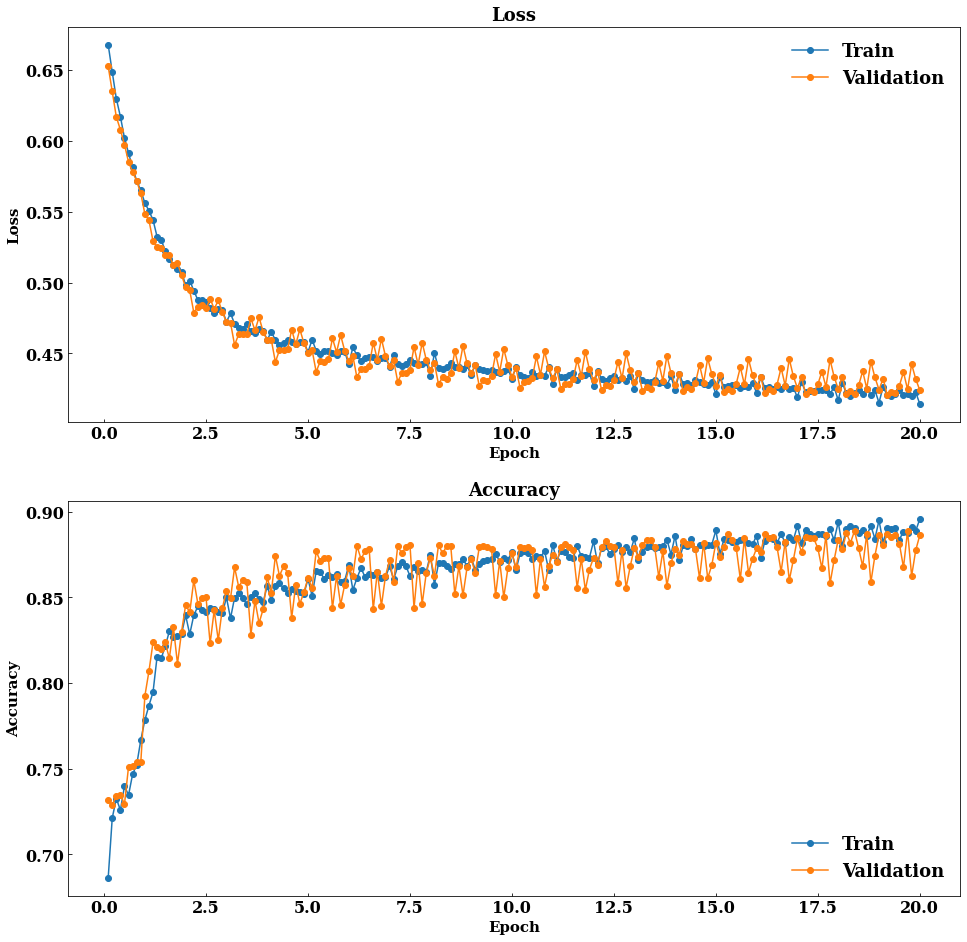

In [16]:
# Visualize training loss and train / val accuracy
fig = plt.figure(figsize=(16,16))
plt.subplot(2, 1, 1)
plt.title('Loss', fontweight='bold', fontsize=18)
plt.plot(np.linspace(0.1,20,200), stats_trained['train loss'], '-o', label='Train')
plt.plot(np.linspace(0.1,20,200), stats_trained['validation loss'], '-o', label='Validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', prop={'size':18}, frameon=False)

plt.subplot(2, 1, 2)
plt.title('Accuracy', fontweight='bold', fontsize=18)
plt.plot(np.linspace(0.1,20,200), stats_trained['train accuracy'], '-o', label='Train')
plt.plot(np.linspace(0.1,20,200), stats_trained['validation accuracy'], '-o', label='Validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', prop={'size':18}, frameon=False)
# plt.gcf().set_size_inches(15, 12)
plt.savefig('./Fig/GoogleNet_result_v5.png')
plt.show()

In [17]:
# Use a test dataset to examine the accuracy
test_set, test_loader = data_loader(data, 80000, 85000)
test_dataloader = torch.utils.data.DataLoader(test_set['validation'], batch_size=64, shuffle=True)

running_corrects = 0
for inputs, labels in test_dataloader:
    
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model_trained(torch.transpose(torch.transpose(inputs, 1, 3), 2, 3))
    # print (outputs)
    
    _, preds = torch.max(outputs, 1)
    # print ('Predictions:', preds)
    running_corrects += torch.sum(preds == labels.data)
    
print ('Test Accuracy:', running_corrects/len(test_set['validation']))

    Number of images with label 1: 1403
Test Accuracy: tensor(0.8990, device='cuda:0')
